In [1]:
import numpy as np
import cv2
import os, glob

In [2]:
parasitized_dir = glob.glob('./Parasitized/*.png')
uninfected_dir = glob.glob('./Uninfected/*.png')
print(len(parasitized_dir), len(uninfected_dir))

13779 13779


In [3]:
width = 128
height = 128

image = []
label = []

for img_path in parasitized_dir:    
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
    img = np.transpose(img, (2, 0, 1)) / 255
    image.append(img)
    label.append(0)

for img_path in uninfected_dir:    
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
    img = np.transpose(img, (2, 0, 1)) / 255
    image.append(img)
    label.append(1)

image = np.array(image)
label = np.array(label)
print(image.shape, label.shape)

(27558, 3, 128, 128) (27558,)


In [5]:
classes = ['parasitized', 'uninfected']

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [7]:
x_train = torch.FloatTensor(image)
y_train = torch.IntTensor(label)

In [8]:
dataset = TensorDataset(x_train, y_train)
train_set, val_set = torch.utils.data.random_split(dataset, [24558, 3000])

In [9]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)

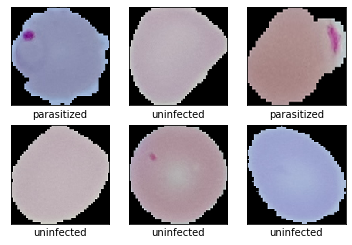

In [11]:
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()

fig = plt.figure()
rows = 2
cols = 3

for i, image in enumerate(images):
    ax = fig.add_subplot(rows, cols, i + 1)
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)
    ax.set_xlabel(classes[int(labels[i])])
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
    if i >= rows * cols:
        break

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 9 * 9, 100),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(100, 6)
        )
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        batch, _, _, _ = x.shape
        x = x.view(batch, -1)
        x = self.fc_layer(x)
        return x

net = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=2592, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=6, bias=True)
  )
)

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [14]:
train_losses, val_losses, accuracy = [], [], []
epochs = 10

for epoch in range(epochs):
    running_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.long()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        val_loss = 0
        val_accuracy = 0
        acc = 0
        
        with torch.no_grad():
            for val_image, val_label in val_loader:
                val_image, val_label = val_image.to(device), val_label.to(device)
                val_label = val_label.long()
                
                val_outputs = net(val_image)
                _, top_class = val_outputs.topk(1, dim=1)
                pred = top_class.cpu().numpy()
                batch, _ = pred.shape
                target = (val_label.cpu().numpy()).reshape(batch, 1)
                
                correct = np.sum(pred == target)
                acc += correct / batch
                
                val_loss += criterion(val_outputs, val_label)

        acc = acc / len(val_loader)
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        accuracy.append(acc)

        print("Epoch: {}/{} || ".format(epoch+1, epochs),
              "Training Loss: {:.5f} || ".format(running_loss/len(train_loader)),
              "Val Loss: {:.5f} || ".format(val_loss/len(val_loader)),
              "Val ACC : {:.5f}".format(acc)
             )

print('Finished Training')

Epoch: 1/10 ||  Training Loss: 0.74049 ||  Val Loss: 0.68835 ||  Val ACC : 0.54808
Epoch: 2/10 ||  Training Loss: 0.68012 ||  Val Loss: 0.56883 ||  Val ACC : 0.73117
Epoch: 3/10 ||  Training Loss: 0.27336 ||  Val Loss: 0.22813 ||  Val ACC : 0.93680
Epoch: 4/10 ||  Training Loss: 0.17587 ||  Val Loss: 0.17435 ||  Val ACC : 0.95326
Epoch: 5/10 ||  Training Loss: 0.15154 ||  Val Loss: 0.16621 ||  Val ACC : 0.95024
Epoch: 6/10 ||  Training Loss: 0.13755 ||  Val Loss: 0.15048 ||  Val ACC : 0.95266
Epoch: 7/10 ||  Training Loss: 0.13098 ||  Val Loss: 0.15034 ||  Val ACC : 0.95717
Epoch: 8/10 ||  Training Loss: 0.12757 ||  Val Loss: 0.13452 ||  Val ACC : 0.95773
Epoch: 9/10 ||  Training Loss: 0.12400 ||  Val Loss: 0.13220 ||  Val ACC : 0.96010
Epoch: 10/10 ||  Training Loss: 0.12136 ||  Val Loss: 0.13252 ||  Val ACC : 0.96010
Finished Training


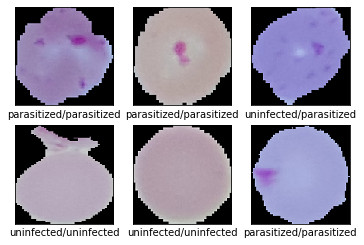

In [30]:
dataiter = iter(val_loader)
inputs, labels = dataiter.next()
images = inputs.numpy()
labels = labels.numpy()

outputs = net(inputs.to(device))
outputs.cpu().detach().numpy()
_, outputs = outputs.topk(1, dim=1)

fig = plt.figure()
rows = 2
cols = 3

for i, image in enumerate(images):
    ax = fig.add_subplot(rows, cols, i + 1)
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)
    ax.set_xlabel(classes[int(labels[i])] + '/' + classes[int(outputs[i])])
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
    if i >= rows * cols:
        break